In [1]:
#IMPORTANT BIT!!! I HAD TO USE THIS TO MAKE GRAPHVIZ WORK. IF IT WORKS ON YOUR DEVICE, JUST '#' IT AWAY.
#If it doesn't, you could either ignore it (I only use it to plot the trees for my xgboost model), or change the path accordingly to your own device.
import os
os.environ['PATH'] += os.pathsep + "C:/Users/mv440/my_project/.venv/Lib/site-packages/graphviz/bin/"

In [2]:
#First we import everything we might need. I am a bit unsure of what model we will end up using, so I will import tensorflow and keras too.

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import joblib
import tensorflow.compat.v1 as tf
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras

C:\Users\mv440\my_project\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [3]:
#Now I am reading the dataset.
EEG = pd.read_csv('EEG_data.csv', encoding='utf-8')
EEG

SubjectID  VideoID  Attention  Mediation    Raw      Delta      Theta  \
0            0.0      0.0       56.0       43.0  278.0   301963.0    90612.0   
1            0.0      0.0       40.0       35.0  -50.0    73787.0    28083.0   
2            0.0      0.0       47.0       48.0  101.0   758353.0   383745.0   
3            0.0      0.0       47.0       57.0   -5.0  2012240.0   129350.0   
4            0.0      0.0       44.0       53.0   -8.0  1005145.0   354328.0   
...          ...      ...        ...        ...    ...        ...        ...   
12806        9.0      9.0       64.0       38.0  -39.0   127574.0     9951.0   
12807        9.0      9.0       61.0       35.0 -275.0   323061.0   797464.0   
12808        9.0      9.0       60.0       29.0 -426.0   680989.0   154296.0   
12809        9.0      9.0       60.0       29.0  -84.0   366269.0    27346.0   
12810        9.0      9.0       64.0       29.0  -49.0  1164555.0  1184366.0   

         Alpha1    Alpha2    Beta1     Beta2   Gamma1   Gamma2  \
0       33735.0   23991.0  27946.0   45097.0  33228.0   8293.0   
1        1439.0    2240.0   2746.0    3687.0   5293.0   2740.0   
2      201999.0   62107.0  36293.0  130536.0  57243.0  25354.0   
3       61236.0   17084.0  11488.0   62462.0  49960.0  33932.0   
4       37102.0   88881.0  45307.0   99603.0  44790.0  29749.0   
...         ...       ...      ...       ...      ...      ...   
12806     709.0   21732.0   3872.0   39728.0   2598.0    960.0   
12807  153171.0  145805.0  39829.0  571280.0  36574.0  10010.0   
12808   40068.0   39122.0  10966.0   26975.0  20427.0   2024.0   
12809   11444.0    9932.0   1939.0    3283.0  12323.0   1764.0   
12810   50014.0  124208.0  10634.0  445383.0  22133.0   4482.0   

       predefinedlabel  user-definedlabeln  
0                  0.0                 0.0  
1                  0.0                 0.0  
2                  0.0                 0.0  
3                  0.0                 0.0  
4                  0.0                 0.0  
...                ...                 ...  
12806              1.0                 0.0  
12807              1.0                 0.0  
12808              1.0                 0.0  
12809              1.0                 0.0  
12810              1.0                 0.0  

[12811 rows x 15 columns]

In [4]:
#We need to manipulate the data a bit now. First, we give each trial timepoints:
EEG = EEG.rename(columns={"user-definedlabeln":"userlabel"})

In [5]:
#I play a bit with the SubjectID and the VideoID:
EEG_new = EEG.reset_index().drop(EEG.index)
for i in range(0,10):
    for j in range(0,10):
        query = "SubjectID == "+str(i)+" &VideoID == "+str(j)
        EEG_temp =  EEG.query(query)
        EEG_temp = EEG_temp.reset_index(drop=True)
        EEG_temp = EEG_temp.reset_index()
        EEG_new = pd.concat([EEG_new, EEG_temp])
EEG_new = EEG_new.rename(columns = {"index":"timepoint"})
EEG_new = EEG_new.reset_index(drop = True)
EEG_new.head()
#We do this because each video is 1 minute long, and the data is recorded every 0.5 seconds. Because of this, we need to set a timescale for each subject's state while watching the videos.

timepoint  SubjectID  VideoID  Attention  Mediation    Raw      Delta  \
0          0        0.0      0.0       56.0       43.0  278.0   301963.0   
1          1        0.0      0.0       40.0       35.0  -50.0    73787.0   
2          2        0.0      0.0       47.0       48.0  101.0   758353.0   
3          3        0.0      0.0       47.0       57.0   -5.0  2012240.0   
4          4        0.0      0.0       44.0       53.0   -8.0  1005145.0   

      Theta    Alpha1   Alpha2    Beta1     Beta2   Gamma1   Gamma2  \
0   90612.0   33735.0  23991.0  27946.0   45097.0  33228.0   8293.0   
1   28083.0    1439.0   2240.0   2746.0    3687.0   5293.0   2740.0   
2  383745.0  201999.0  62107.0  36293.0  130536.0  57243.0  25354.0   
3  129350.0   61236.0  17084.0  11488.0   62462.0  49960.0  33932.0   
4  354328.0   37102.0  88881.0  45307.0   99603.0  44790.0  29749.0   

   predefinedlabel  userlabel  
0              0.0        0.0  
1              0.0        0.0  
2              0.0        0.0  
3              0.0        0.0  
4              0.0        0.0

<Axes: >

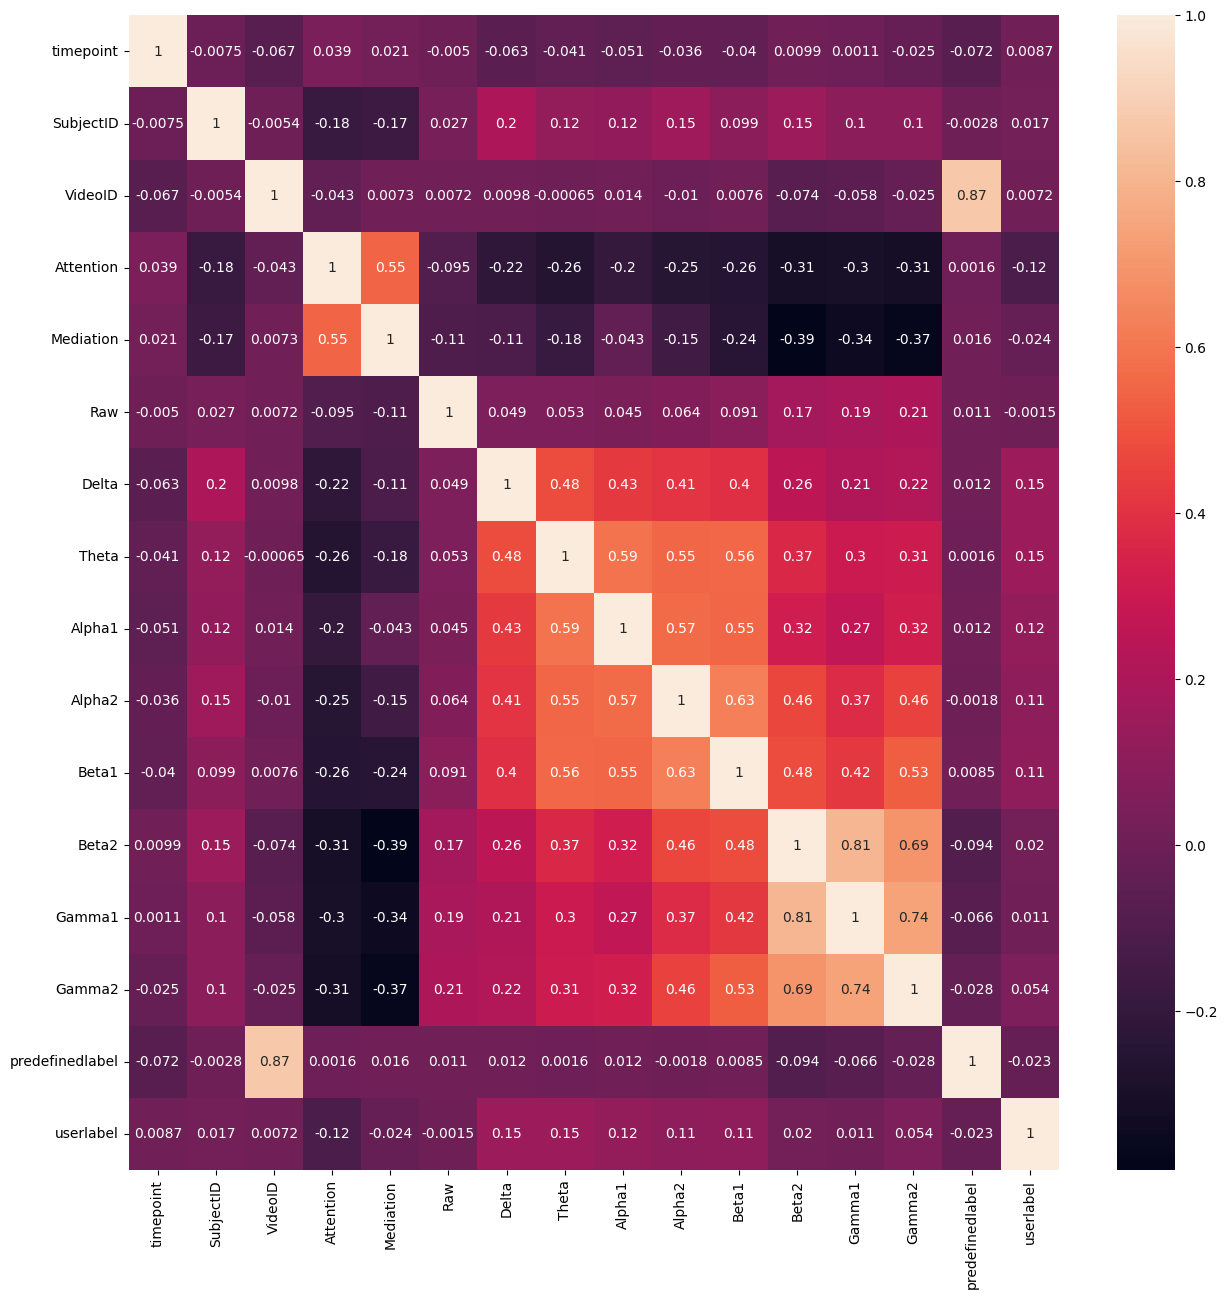

In [6]:
#We are looking for correlations between each feature now using a heatmap:
plt.figure(figsize = (15, 15))
cor_matrix  = EEG_new.corr()
sns.heatmap(cor_matrix, annot = True)

In [7]:
#First problem we encounter is labeling. Whether the subject was 'confused' or 'not confused' is somehow subjective, so we have that labeled by the two involved parties:
#The author, and the subject. So, we will categorize our timepoint signals according to 3 categories:
#Labeled by the author, labeled by the subject, and labeled by both. Once these are categorizes, we will average the signals for each timepoint.
def draw_fig(EEG_confused, EEG_nconfused, filename):
    sns.set(rc = {'figure.figsize':(30, 8.27)})
    fig, axs = plt.subplots(5,2)

    sns.lineplot(data=EEG_confused, x="timepoint", y="Attention",errorbar=None, ax=axs[0,0])
    sns.lineplot(data=EEG_nconfused, x="timepoint", y="Attention",errorbar=None, ax=axs[0,0])

    sns.lineplot(data=EEG_confused, x="timepoint", y="Mediation",errorbar=None, ax=axs[0,1])
    sns.lineplot(data=EEG_nconfused, x="timepoint", y="Mediation",errorbar=None, ax=axs[0,1])

    sns.lineplot(data=EEG_confused, x="timepoint", y="Alpha1",errorbar=None, ax=axs[1,0])
    sns.lineplot(data=EEG_nconfused, x="timepoint", y="Alpha1",errorbar=None, ax=axs[1,0])

    sns.lineplot(data=EEG_confused, x="timepoint", y="Alpha2",errorbar=None, ax=axs[1,1])
    sns.lineplot(data=EEG_nconfused, x="timepoint", y="Alpha2",errorbar=None, ax=axs[1,1])

    sns.lineplot(data=EEG_confused, x="timepoint", y="Beta1",errorbar=None, ax=axs[2,0])
    sns.lineplot(data=EEG_nconfused, x="timepoint", y="Beta1",errorbar=None, ax=axs[2,0])

    sns.lineplot(data=EEG_confused, x="timepoint", y="Beta2",errorbar=None, ax=axs[2,1])
    sns.lineplot(data=EEG_nconfused, x="timepoint", y="Beta2",errorbar=None, ax=axs[2,1])

    sns.lineplot(data=EEG_confused, x="timepoint", y="Gamma1",errorbar=None, ax=axs[3,0])
    sns.lineplot(data=EEG_nconfused, x="timepoint", y="Gamma1",errorbar=None, ax=axs[3,0])

    sns.lineplot(data=EEG_confused, x="timepoint", y="Gamma2",errorbar=None, ax=axs[3,1])
    sns.lineplot(data=EEG_nconfused, x="timepoint", y="Gamma2",errorbar=None, ax=axs[3,1])

    sns.lineplot(data=EEG_confused, x="timepoint", y="Delta",errorbar=None, ax=axs[4,0])
    sns.lineplot(data=EEG_nconfused, x="timepoint", y="Delta",errorbar=None, ax=axs[4,0])

    sns.lineplot(data=EEG_confused, x="timepoint", y="Theta",errorbar=None, ax=axs[4,1])
    sns.lineplot(data=EEG_nconfused, x="timepoint", y="Theta",errorbar=None, ax=axs[4,1])

    fig.legend(labels = ['Confused', 'Not Confused'], loc = "lower center", ncol = 2)
    fig.suptitle("Confused vs. Not Confused by Frequencies")

    plt.savefig(filename, bbox_inches = 'tight')
    plt.show()

    
    



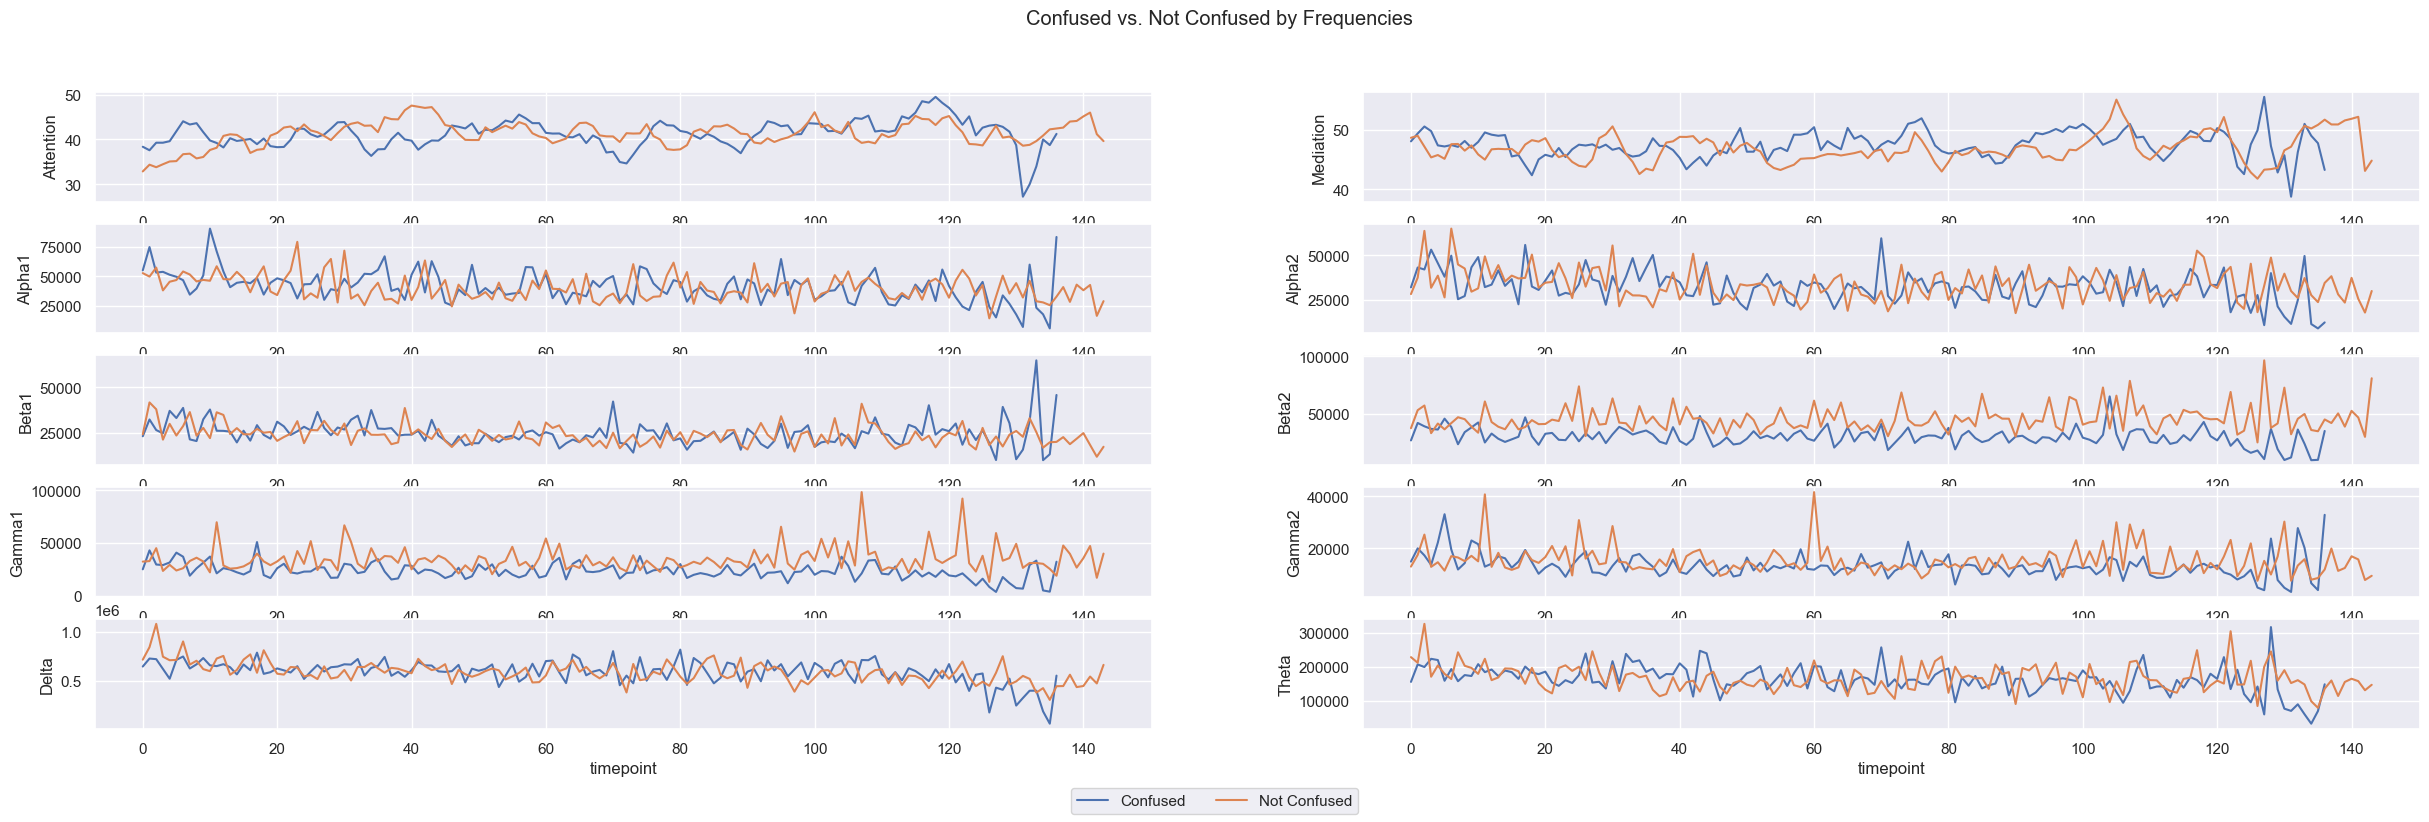

In [8]:
#Now we look at the labeling of the author, and we used the def we wrote in the previous box to get our graphs:
query = "predefinedlabel == 1"
EEG_confused = EEG_new.query(query)

query = "predefinedlabel == 0"
EEG_nconfused = EEG_new.query(query)

draw_fig(EEG_confused, EEG_nconfused, "Confused vs. Not Confused by Author Labeling.png")

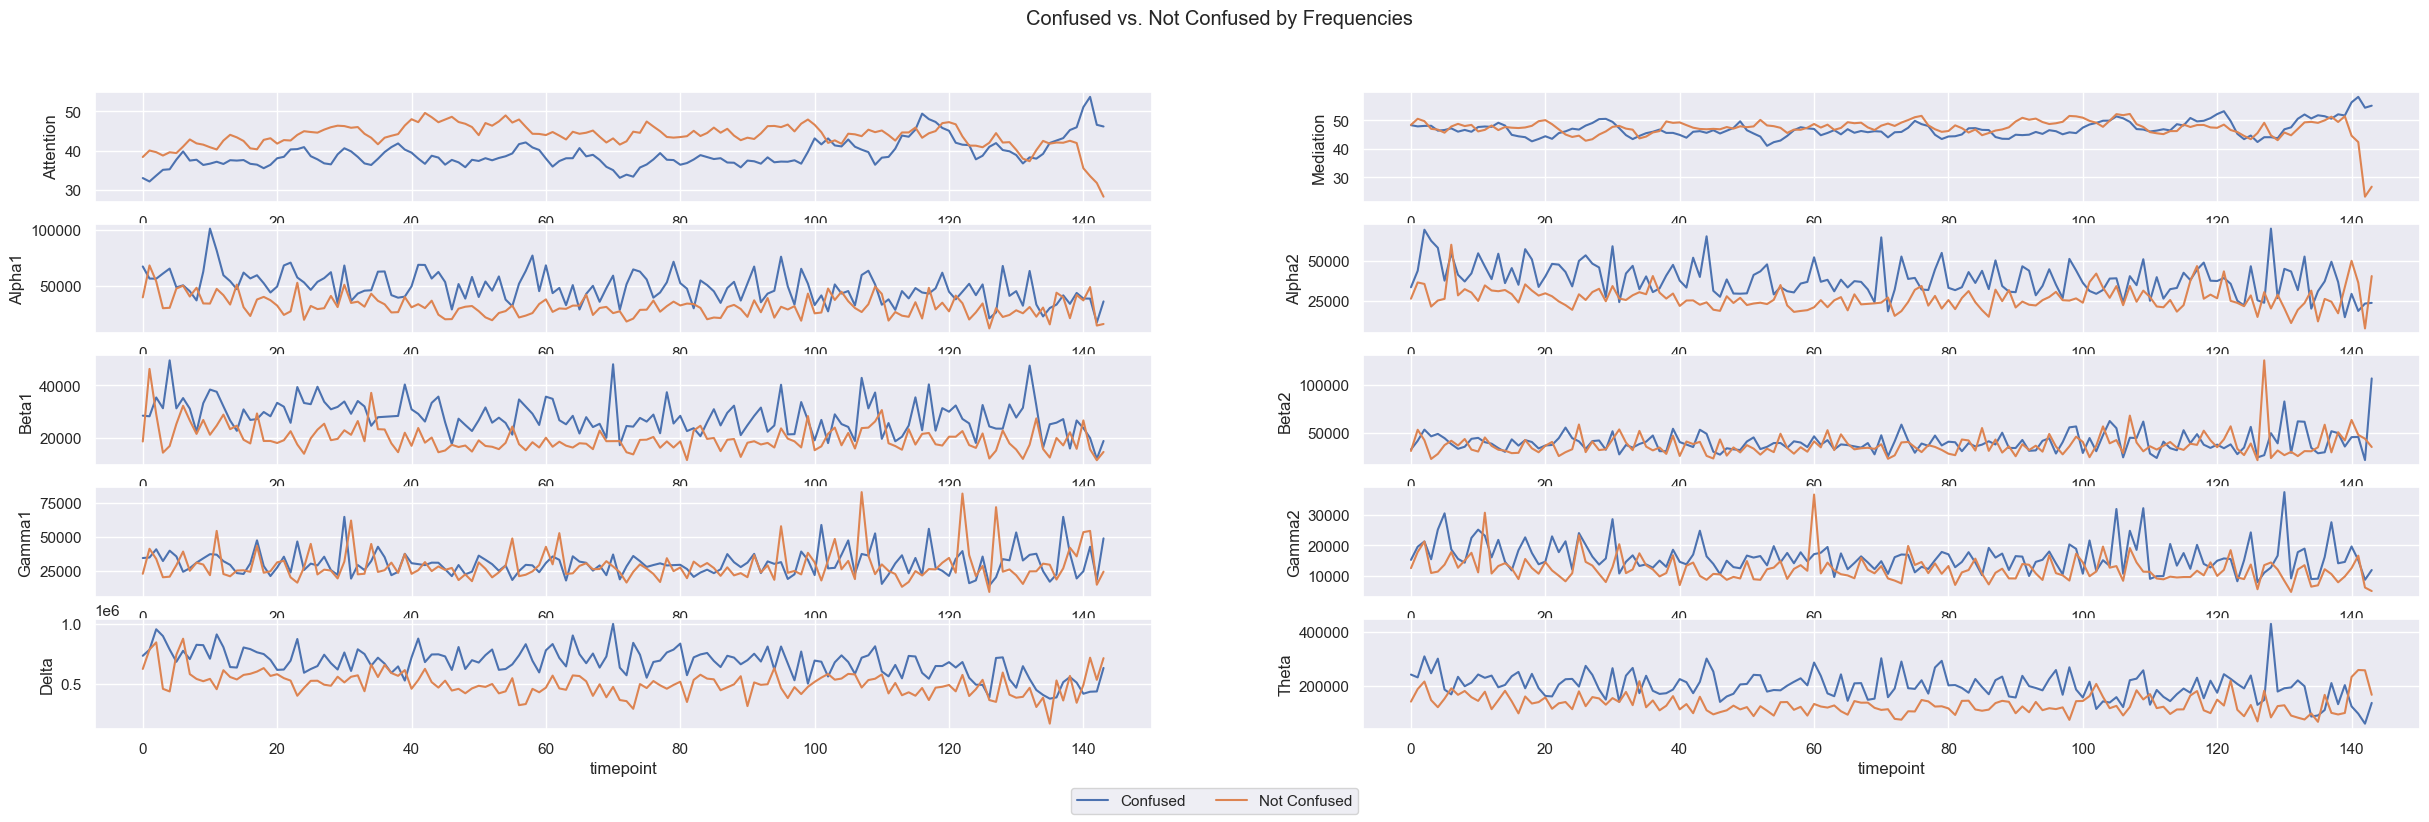

In [9]:
#Now we do the exact same thing, but labeled by the subjects:
query = "userlabel == 1"
EEG_confused = EEG_new.query(query)

query = "userlabel == 0"
EEG_nconfused = EEG_new.query(query)

draw_fig(EEG_confused, EEG_nconfused, "Confused vs. Not Confused by Subject Labeling.png")

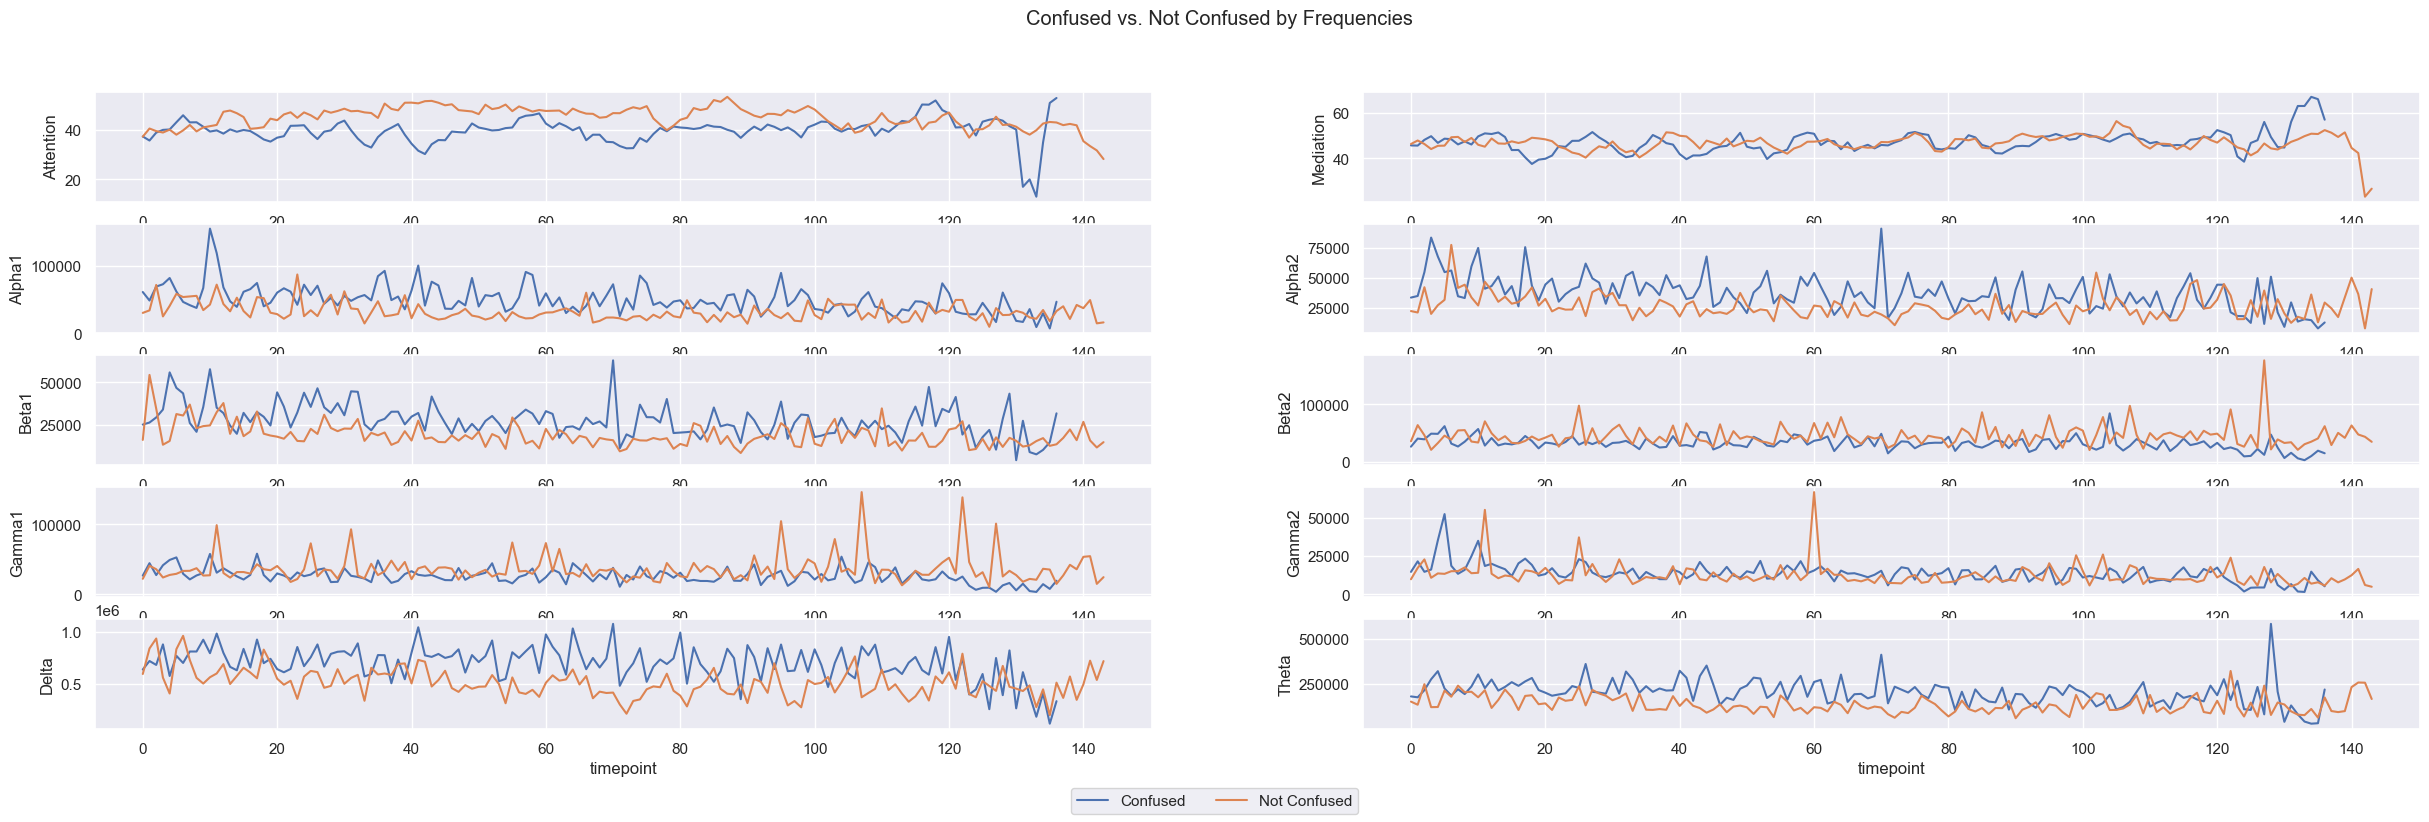

In [10]:
#Now we must look for how the data looks when the subject and the authors 'agreed' on whether the video was confusing or not:
query = "predefinedlabel == 1 & userlabel == 1"
EEG_confused = EEG_new.query(query)

query = "predefinedlabel == 0 & userlabel == 0"
EEG_nconfused = EEG_new.query(query)

draw_fig(EEG_confused, EEG_nconfused, "Confused vs. Not Confused by Subject & Author Labeling.png")

In [11]:
#Now we prepare the training dataset. For this, we will consider only the same-labeled data by both the Author and the Subjects:
EEG_f = EEG_new.query("(predefinedlabel == 0 & userlabel == 0) | (predefinedlabel == 1 & userlabel == 1)")
X = EEG_f[['Delta','Theta','Alpha1','Alpha2','Beta1','Beta2','Gamma1','Gamma2']]
	
print(X.isna().sum())
print(X.shape)
y = EEG_f.predefinedlabel
print(y.shape)
#EEG_f represents the final data set that only includes data both the author and the subjects agree on.

Delta     0
Theta     0
Alpha1    0
Alpha2    0
Beta1     0
Beta2     0
Gamma1    0
Gamma2    0
dtype: int64
(6253, 8)
(6253,)


In [12]:
#We check the shape of the new dataset:
print(EEG_f[EEG_f['predefinedlabel'] == 1].shape)
print(EEG_f[EEG_f['predefinedlabel'] == 0].shape)
print(EEG_f.shape)

(3079, 16)
(3174, 16)
(6253, 16)


In [13]:
#For our model, we will attempt to use a classification model. I am not entirely sure which one should work best. The dataset warns us that 
#the data is actually pretty hard to classify with high accuracy, the highest accuracy being 75% with a simple model. I will try to use XGBoost,
#and go from there if there is a way to improve it.
def classify (X, y):
    import xgboost
    import graphviz
    from xgboost import plot_tree, plot_importance
    from matplotlib.pylab import rcParams
    from sklearn.metrics import accuracy_score
    from sklearn.model_selection import StratifiedKFold, cross_val_score

    random_state = 42
    #I split the dataset into training and testing:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state, stratify = y)
    #Start the xgboost model:
    model = xgboost.XGBClassifier(base_score = 0.5, learning_rate = 0.15, max_depth = 6, objective = 'binary:logistic', eta = 0.01)
    model.fit(X_train, y_train)
    #We round up the predictions:
    y_pred = model.predict(X_test)
    preds = [round(k) for k in y_pred]

    accuracy = accuracy_score(y_test, preds)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

    #We also draw, and save the tree:
    rcParams['figure.figsize'] = 80, 50
    plot_tree(model)
    plt.savefig("tree_plot.png", bbox_inches='tight')
    plt.show()
    #There are some issues here with the Graphviz path folder. I require admin access to fix this. I managed to fix it eventually,
    #but hopefully you won't have any issues with running it. I did it using the first box by rewriting the path for the graphviz package.
    #If it doesn't work for you, just add '#' before these 4 lines. It's just the model tree.

    #We do k-fold validation with 5 folds:
    kfold = StratifiedKFold(n_splits = 5)
    results = cross_val_score(model, X, y, cv = kfold)
    print("Cross Validation Accuracy: %.2f%% (%.2f%%)" % (results.mean() * 100, results.std() * 100))
    print("")
    print("---------------------------------------------------------------------")
    print("")

    #Finally, we print the feature importance for this model.
    print("Feature Importance")
    rcParams['figure.figsize'] = 5, 5
    plot_importance(model)
    plt.savefig("feature_importance.png", bbox_inches = 'tight')
    plt.show()

Accuracy: 66.59%


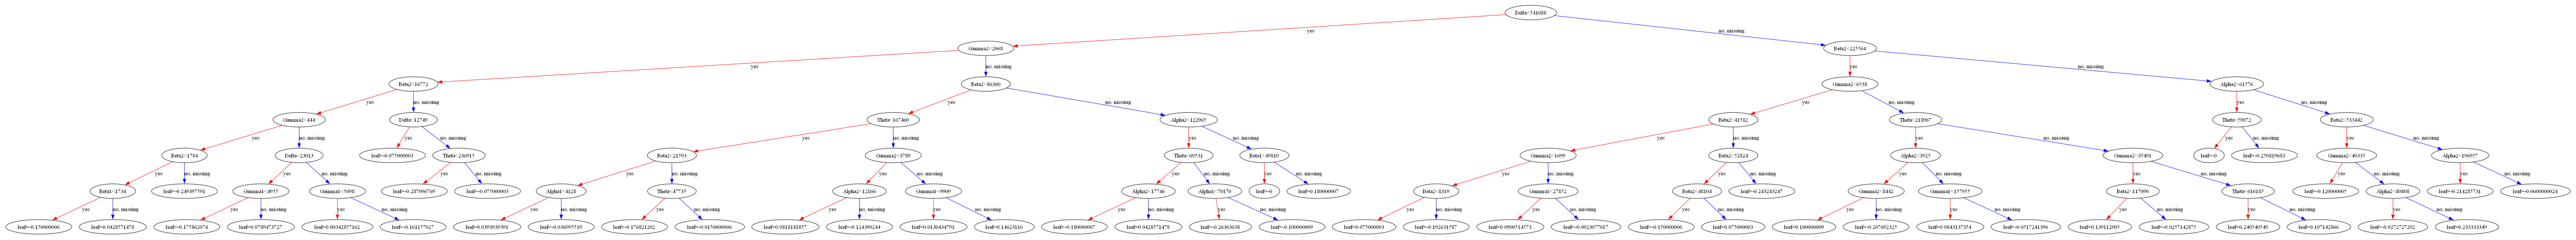

Cross Validation Accuracy: 61.52% (5.19%)

---------------------------------------------------------------------

Feature Importance


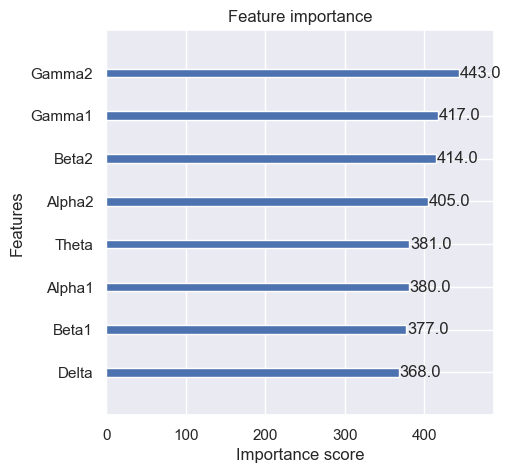

In [14]:
#Now that we have our 'classify' function, let's apply the model to our data and see how it looks like:
classify(X, y)

In [15]:
#Not ideal scores. We must look to improve them. One way to do that is to use a moving average. We currently have dispersed values, so we can
#re-classify them. This is similar to a scaling.
def mov_ave(x, w = 10):
    return np.convolve(x, np.ones(w), 'valid') / w

In [16]:
#We prepare the dataset:
EEG_ave = pd.DataFrame(columns = ['Attention','Mediation','Delta','Theta','Alpha1','Alpha2','Beta1','Beta2','Gamma1','Gamma2','Label'])

In [17]:
#This is where we apply the moving average. It is a bit complicated, but couldn't figure out another way to do it.
#Basically, for every subject, for every video they watched, I look at all the relevant features (all of them for now), and I average them
#to get rid of short-term fluctuations. Considering we are dealing with brainwaves, this might improve our model by a lot, as it 
#takes care of the noise in the data. I really hope this is the right way to do a moving average though.
for i in range(int(EEG_f.SubjectID.min()), int(EEG_f.SubjectID.max()+1)):
  for j in range(int(EEG_f.VideoID.min()), int(EEG_f.VideoID.max()+1)):
    for k in range(0,2):
      if len(EEG_f[(EEG_f.predefinedlabel == k) & (EEG_f.SubjectID == i) & (EEG_f.VideoID == j)].Attention) > 0 :
        attention = mov_ave(EEG_f[(EEG_f.predefinedlabel == k) & (EEG_f.SubjectID == i) & (EEG_f.VideoID == j)].Attention)
        mediation = mov_ave(EEG_f[(EEG_f.predefinedlabel == k) & (EEG_f.SubjectID == i) & (EEG_f.VideoID == j)].Mediation)
        delta = mov_ave(EEG_f[(EEG_f.predefinedlabel == k) & (EEG_f.SubjectID == i) & (EEG_f.VideoID == j)].Delta)
        theta = mov_ave(EEG_f[(EEG_f.predefinedlabel == k) & (EEG_f.SubjectID == i) & (EEG_f.VideoID == j)].Theta)
        alpha1 = mov_ave(EEG_f[(EEG_f.predefinedlabel == k) & (EEG_f.SubjectID == i) & (EEG_f.VideoID == j)].Alpha1)
        alpha2 = mov_ave(EEG_f[(EEG_f.predefinedlabel == k) & (EEG_f.SubjectID == i) & (EEG_f.VideoID == j)].Alpha2)
        beta1 = mov_ave(EEG_f[(EEG_f.predefinedlabel == k) & (EEG_f.SubjectID == i) & (EEG_f.VideoID == j)].Beta1)
        beta2 = mov_ave(EEG_f[(EEG_f.predefinedlabel == k) & (EEG_f.SubjectID == i) & (EEG_f.VideoID == j)].Beta2)
        gamma1 = mov_ave(EEG_f[(EEG_f.predefinedlabel == k) & (EEG_f.SubjectID == i) & (EEG_f.VideoID == j)].Gamma1)
        gamma2 = mov_ave(EEG_f[(EEG_f.predefinedlabel == k) & (EEG_f.SubjectID == i) & (EEG_f.VideoID == j)].Gamma2)
        if k == 1:
          label = np.ones(len(attention))
        else:
          label = np.zeros(len(attention))
        timepoint = np.arange(len(attention))
        array = np.stack((timepoint, attention, mediation, delta, theta, alpha1, alpha2, beta1, beta2, gamma1, gamma2, label))
        array = np.transpose(array)
        #As a last step, we concatenate the 'temporary' dataset we have of moving averages into the EEG_ave, which is our averaged data.
        EEG_temp = pd.DataFrame(array, columns = ['timepoint','Attention','Mediation','Delta','Theta','Alpha1','Alpha2','Beta1','Beta2','Gamma1','Gamma2','Label'])
        EEG_ave = pd.concat([EEG_ave, EEG_temp])

print(EEG_ave)

C:\Users\mv440\AppData\Local\Temp\ipykernel_23736\1395349645.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  EEG_ave = pd.concat([EEG_ave, EEG_temp])


     Attention  Mediation     Delta     Theta   Alpha1   Alpha2    Beta1  \
0         45.1       57.0  730906.7  153457.8  59794.7  38078.0  22875.2   
1         44.3       56.5  776426.9  163016.2  56745.4  36063.0  21966.0   
2         44.7       57.8  835799.5  174393.3  64106.5  37462.4  26284.0   
3         44.7       56.4  776500.2  140230.7  44222.4  31877.3  23381.7   
4         44.8       53.7  649042.7  135723.2  38322.3  34043.7  24403.4   
..         ...        ...       ...       ...      ...      ...      ...   
110       59.7       52.9  696266.1  134271.3  24167.2  19734.7  20748.9   
111       59.4       52.6  728067.2  147023.7  47176.4  24000.7  27738.6   
112       56.8       51.9  647406.8  141006.7  45746.4  23283.2  23621.7   
113       55.9       51.9  790189.1  159394.5  47639.8  23119.3  25662.5   
114       54.1       52.1  789421.8  161619.5  47606.7  23170.1  25701.0   

       Beta2   Gamma1   Gamma2  Label  timepoint  
0    54852.8  39680.7  25812.9    0.

In [18]:
#Now, we just rerun the model, but with the averaged data:
X_ave = EEG_ave[['Delta','Theta','Alpha1','Alpha2','Beta1','Beta2','Gamma1','Gamma2']]
	
print(X.isna().sum())
print(X.shape)
y_ave = EEG_ave.Label
print(y.shape)

Delta     0
Theta     0
Alpha1    0
Alpha2    0
Beta1     0
Beta2     0
Gamma1    0
Gamma2    0
dtype: int64
(6253, 8)
(6253,)


Accuracy: 90.03%


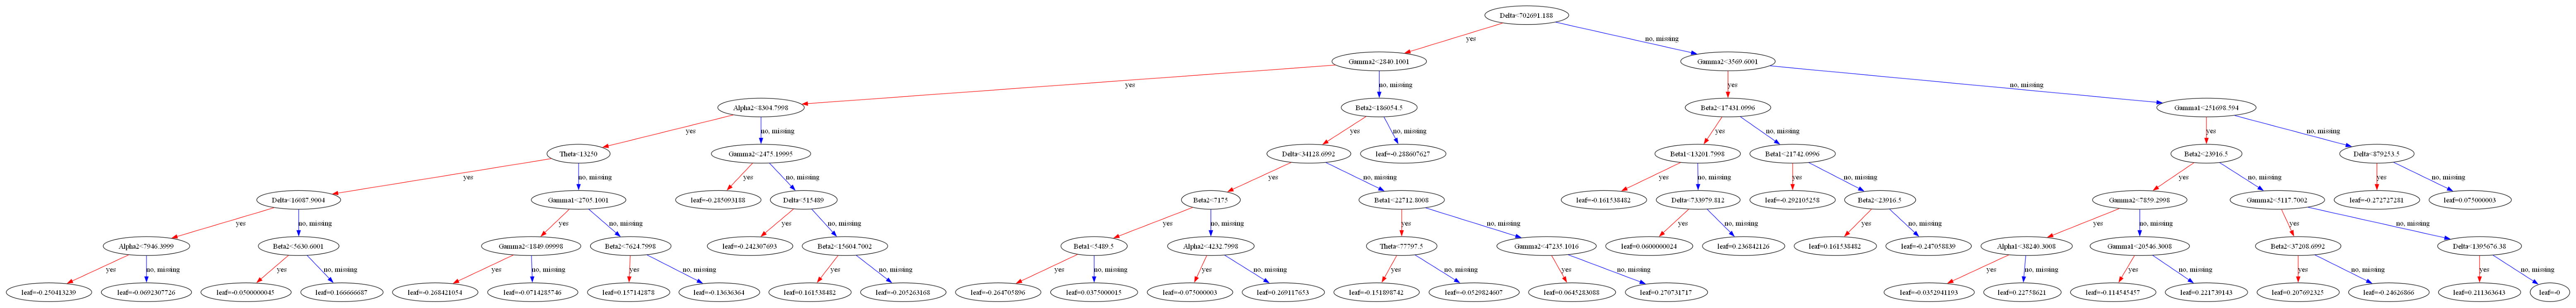

Cross Validation Accuracy: 68.22% (12.26%)

---------------------------------------------------------------------

Feature Importance


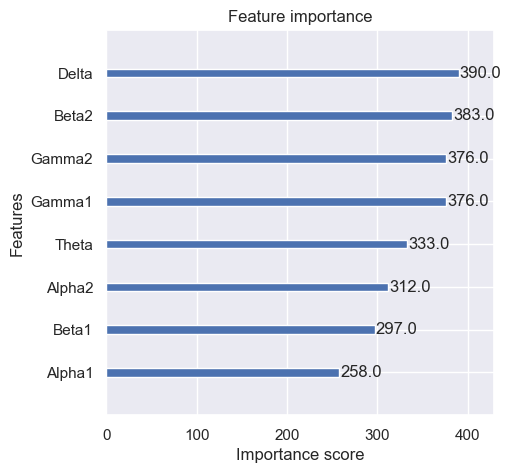

In [19]:
classify(X_ave,y_ave)

In [20]:
#Much better accuracy, but very low cross-validation. This leads to a problem. For that, I will try to use tensorflow.
#I will attempt to use Bidirectional Long Short Term Memory. We start by using the averaged dataset. First thing we do is scale the measurements.
#I will use a StandardScaler.
from sklearn.preprocessing import StandardScaler

X_ave = EEG_ave[['Delta','Theta','Alpha1','Alpha2','Beta1','Beta2','Gamma1','Gamma2']]

X_lstm = StandardScaler().fit_transform(X_ave)
y_lstm = y_ave
#We split the data, and we stratify it:
X_train,X_test,y_train,y_test = train_test_split(X_lstm, y_lstm, test_size = 0.2, random_state=42, stratify = y_lstm)


n_features = X_ave.shape[1]
X_train = np.array(X_train).reshape(-1,n_features,1)
X_test = np.array(X_test).reshape(-1,n_features,1)

X_train.shape, X_test.shape,y_train.shape,y_test.shape

((4649, 8, 1), (1163, 8, 1), (4649,), (1163,))

In [21]:
#Now we start a keras tensor:
inputs = tf.keras.Input(shape = (n_features,1))
#We initialize a dense layer with 64 neurons. We will use relu, as we only care about positive outputs:
dense1 = Dense(64, activation = 'relu',kernel_regularizer=keras.regularizers.l2())(inputs)
#We will also drop some neurons, to avoid overfitting. I will also use bidirectional wrapper, I believe having a Recurrent Neural Network
#is the best option for this dataset:
lstm_1 =  Bidirectional(LSTM(256, return_sequences = True))(dense1)
drop = Dropout(0.3)(lstm_1)
lstm_3 =  Bidirectional(LSTM(128, return_sequences = True))(drop)
drop2 = Dropout(0.3)(lstm_3)
#I flatten it now, so that the tensor is the correct size:
flat = Flatten()(drop2)
#Now I add a second dense layer of neurons:
dense_2 = Dense(128, activation = 'relu')(flat)
outputs = Dense(1, activation = 'sigmoid')(dense_2)
#Ideally, we want a binary classification, so sigmoid works great for us, labeling the final result as either Confused, or Not Confused.
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 8, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8, 64)               │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 8, 512)              │         657,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 8, 256)              │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,576,321 (6.01 MB)

 Trainable params: 1,576,321 (6.01 MB)

 Non-trainable params: 0 (0.00 B)

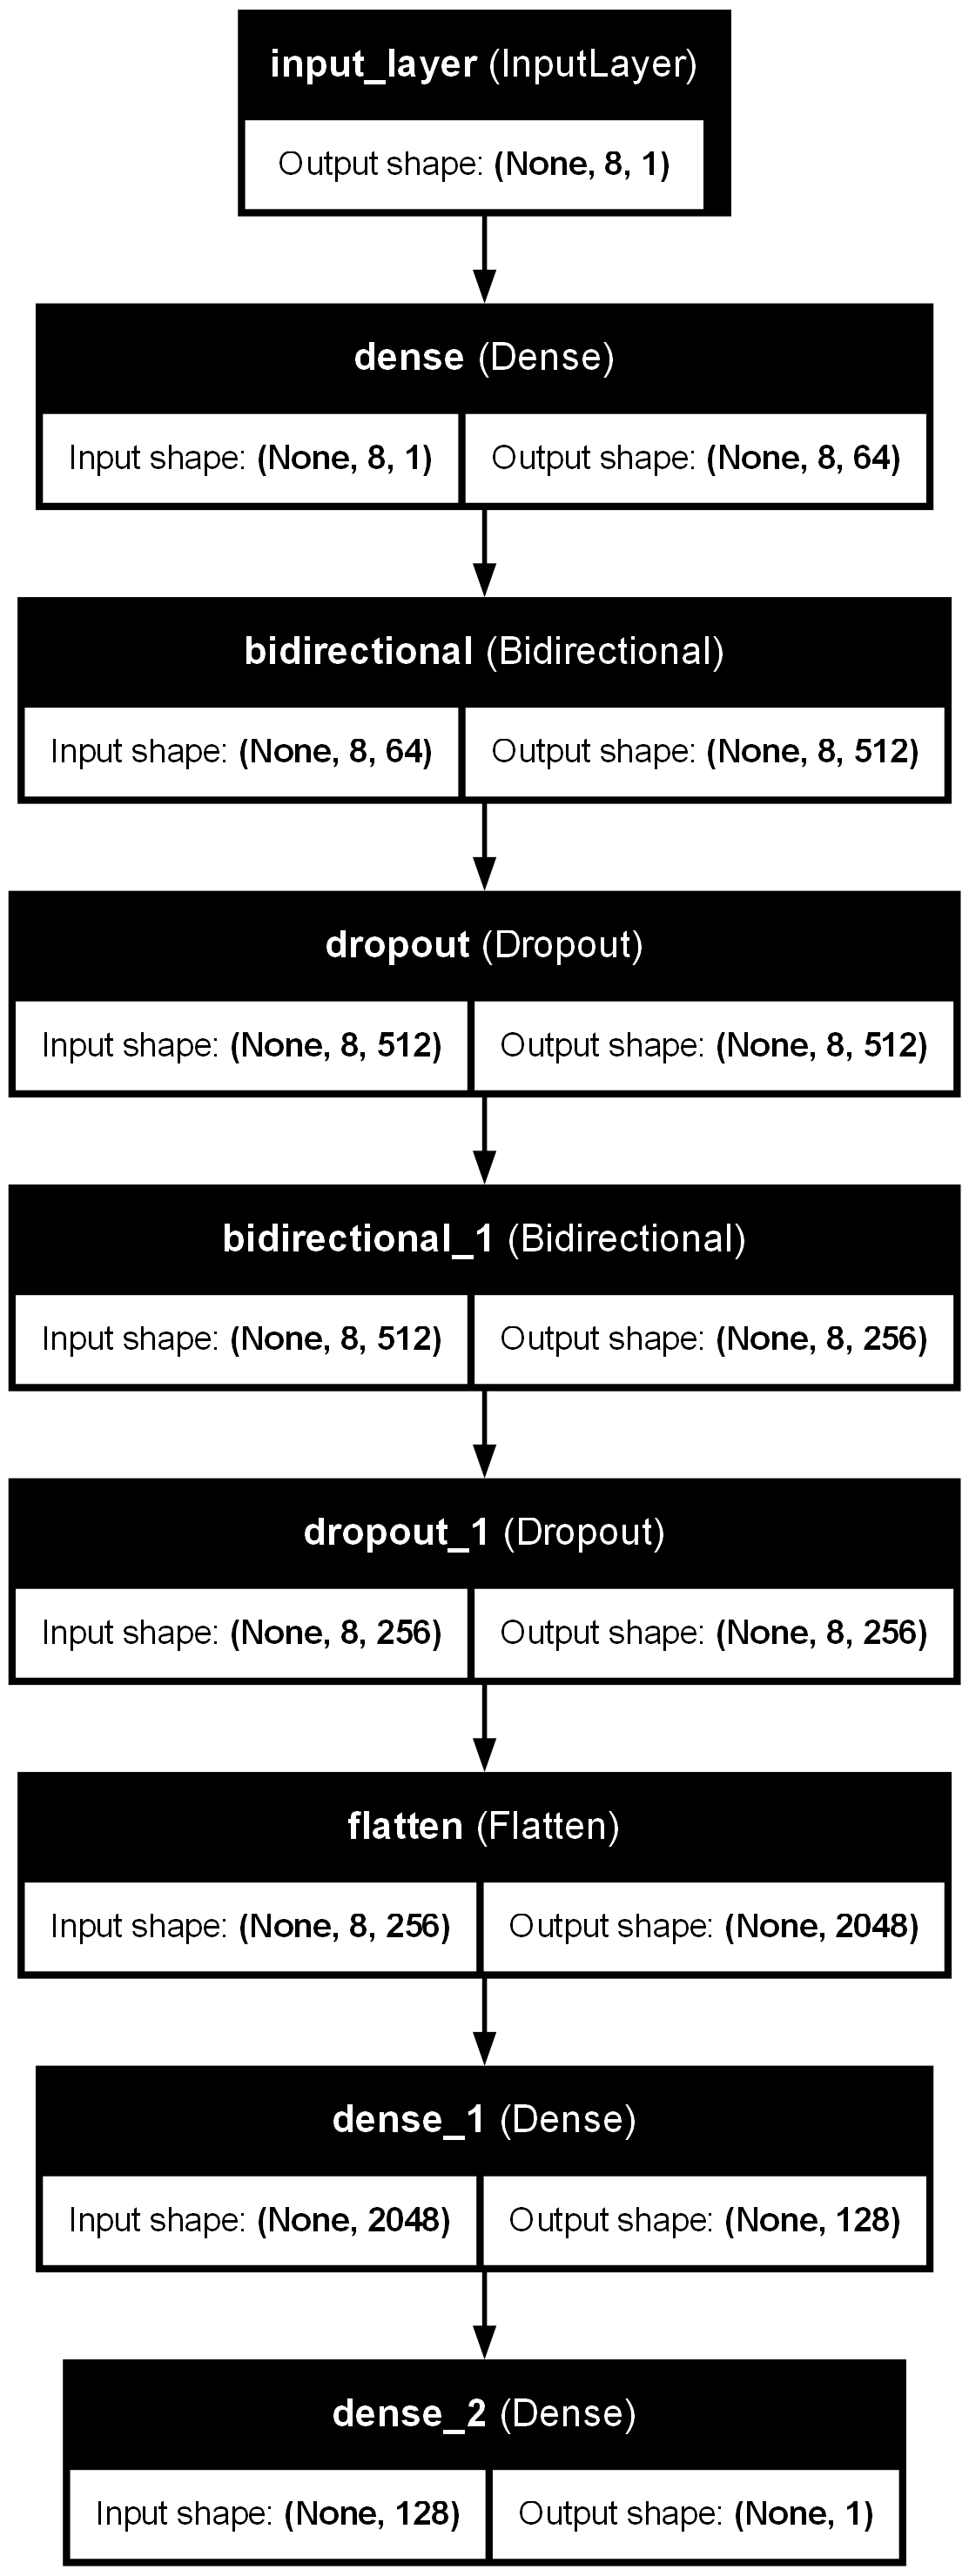

In [22]:
#I will also plot the arhitecture of the model, to be more easily seen:
tf.keras.utils.plot_model(model, to_file = 'model_architecture.png', show_shapes = True, show_layer_names = True)

In [23]:
#We train the model function now:
#Ideally we want to have a good number of folds, each with a large number of epochs.
def train_model(model, X_train, y_train, X_test, y_test, save_to, kfold_order = None, epoch=2):
    if not kfold_order:
        kfold_order = 'singleTrial'
    else:
        print("=============================================================")
        print("Training for fold no " + str(kfold_order))
        print("=============================================================")
    #We use Adam, as we are mostly interested in first and second order moments:
    opt_adam = tf.keras.optimizers.Adam(learning_rate = 0.001)
    #Here we define some parameters that we need:
    #es will stop the training when a metric stops improving.
    #mc will save the weights at certain intervals to ensure optimal training.
    #lr_schedule updates the learning rate at an exponential rate.
    es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)
    mc = ModelCheckpoint(save_to + '_best_model_' + str(kfold_order) + '.keras', monitor = 'val_accuracy', mode = 'max', verbose = 0, save_best_only = True)
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))

    model.compile(optimizer = opt_adam, loss = ['binary_crossentropy'], metrics = ['accuracy'])
    
    history = model.fit(X_train, y_train,
                        batch_size = 20,
                        epochs = epoch,
                        validation_data = (X_test, y_test),
                        callbacks = [es, mc, lr_schedule], verbose = 0)

    saved_model = load_model(save_to + '_best_model_' + str(kfold_order) + '.keras')

    from matplotlib.pylab import rcParams
    rcParams['figure.figsize'] = 5, 5

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    #Summarize the history:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    return model, history

Training for fold no 1


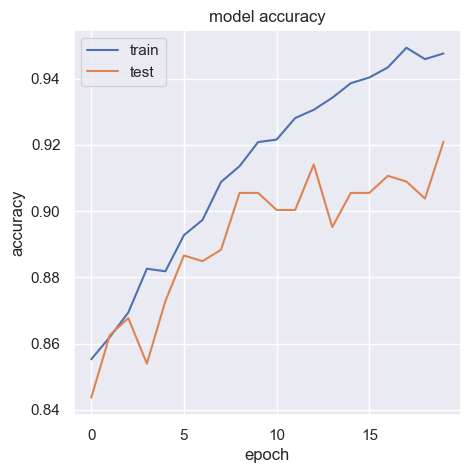

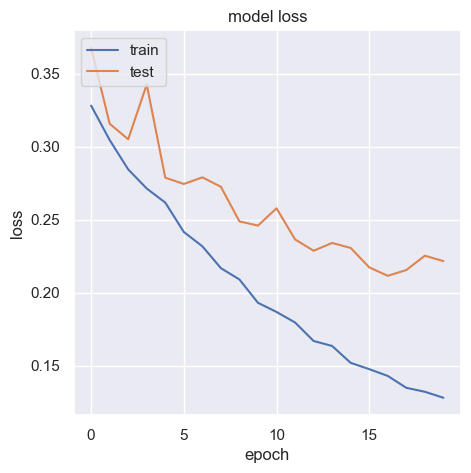

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9210 - loss: 0.2216
Metrics names: ['loss', 'compile_metrics']

Training for fold no 2


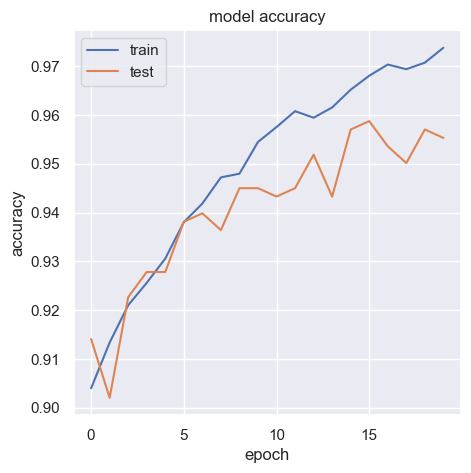

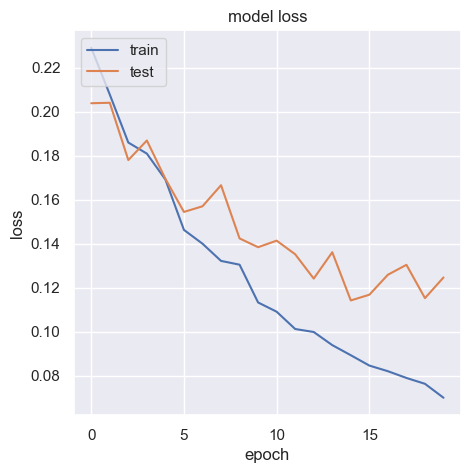

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9588 - loss: 0.1168
Metrics names: ['loss', 'compile_metrics']
Training for fold no 3


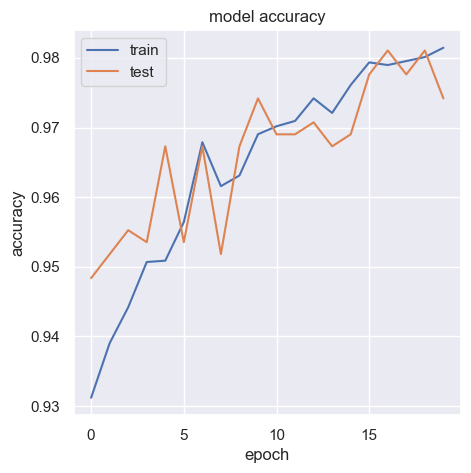

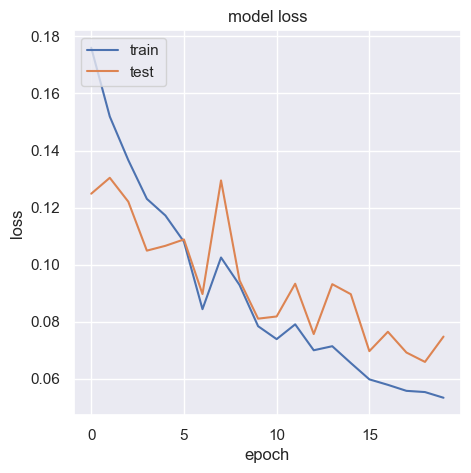

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9811 - loss: 0.0764
Metrics names: ['loss', 'compile_metrics']
Training for fold no 4


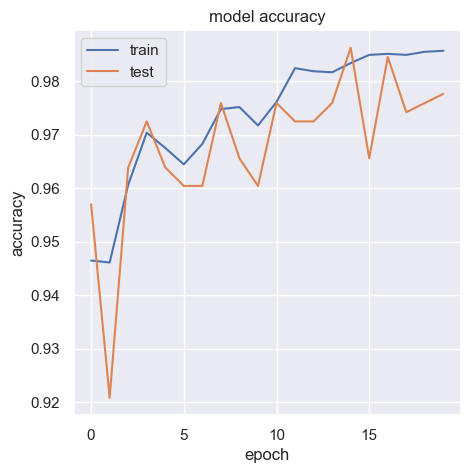

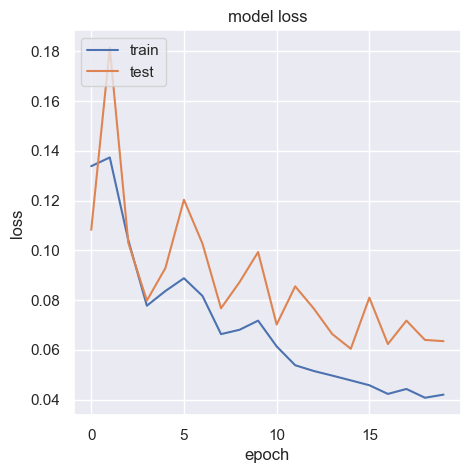

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9862 - loss: 0.0604
Metrics names: ['loss', 'compile_metrics']
Training for fold no 5
Epoch 18: early stopping


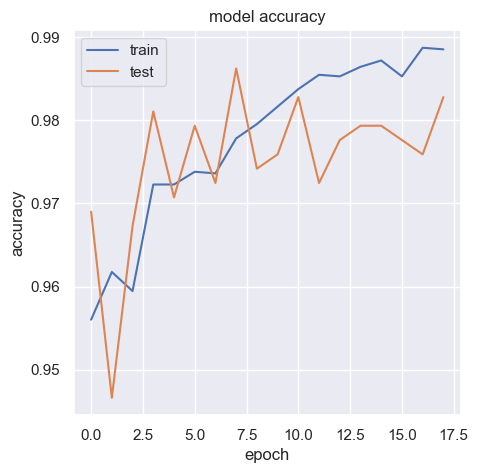

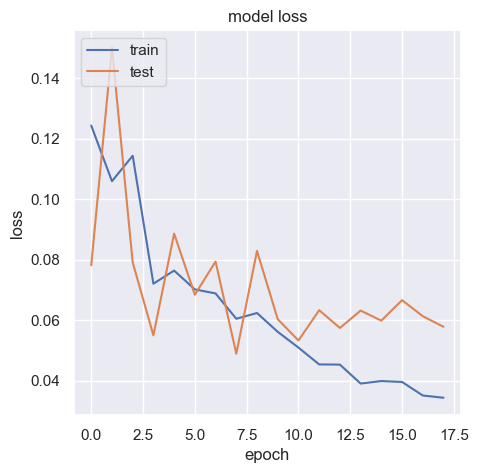

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9862 - loss: 0.0490
Metrics names: ['loss', 'compile_metrics']
Training for fold no 6


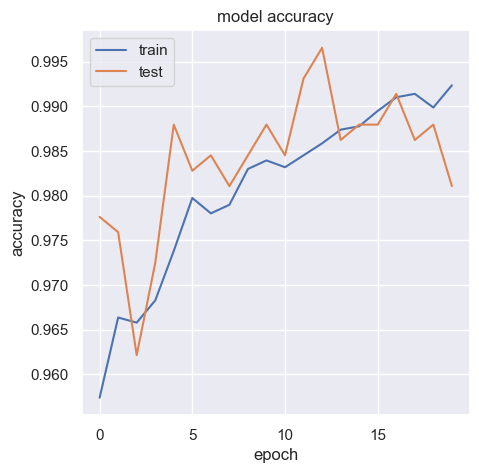

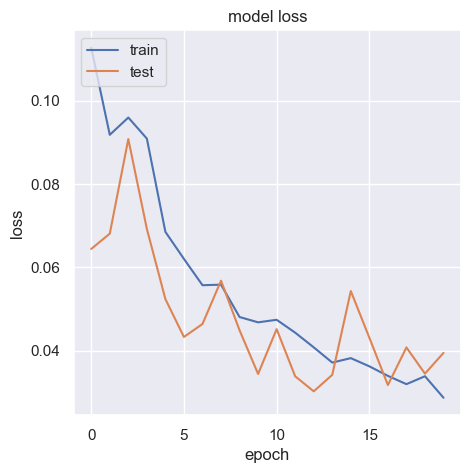

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9966 - loss: 0.0302
Metrics names: ['loss', 'compile_metrics']
Training for fold no 7


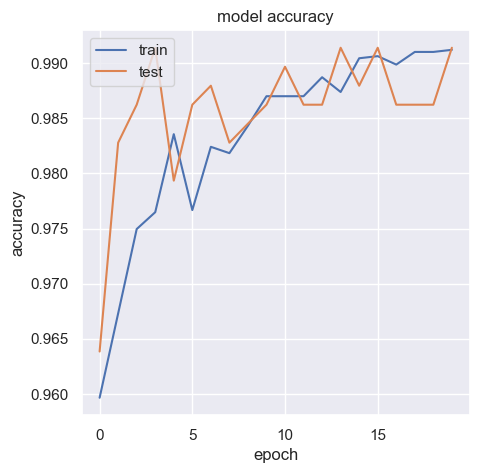

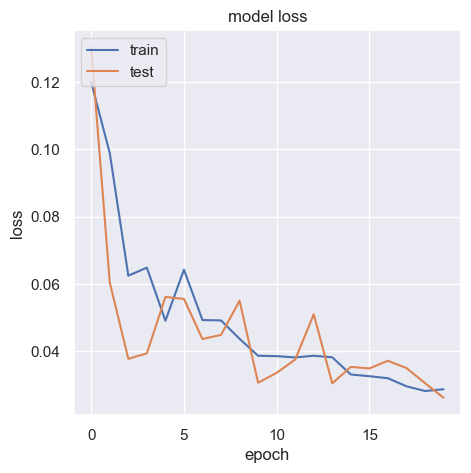

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9914 - loss: 0.0394
Metrics names: ['loss', 'compile_metrics']
Training for fold no 8


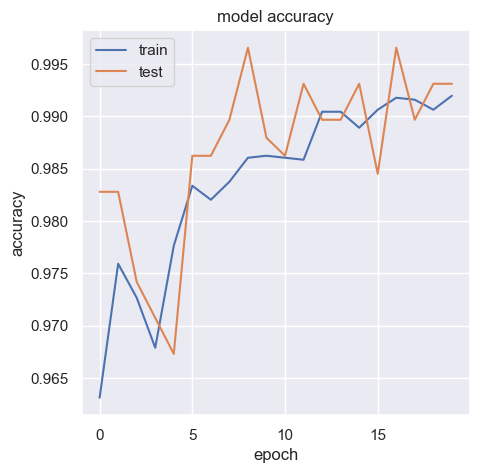

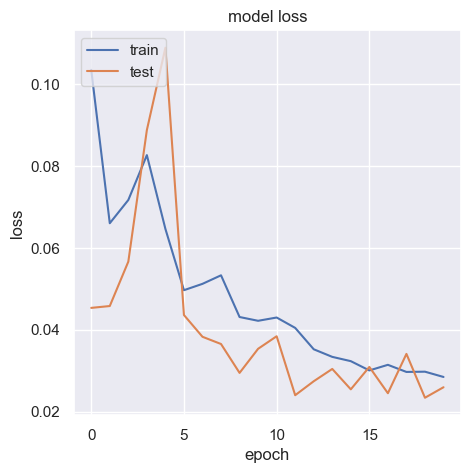

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9966 - loss: 0.0295
Metrics names: ['loss', 'compile_metrics']
Training for fold no 9


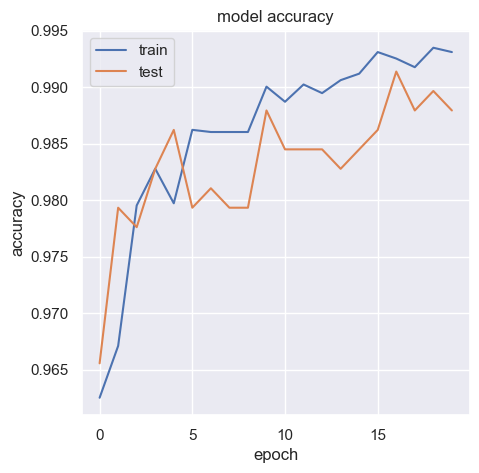

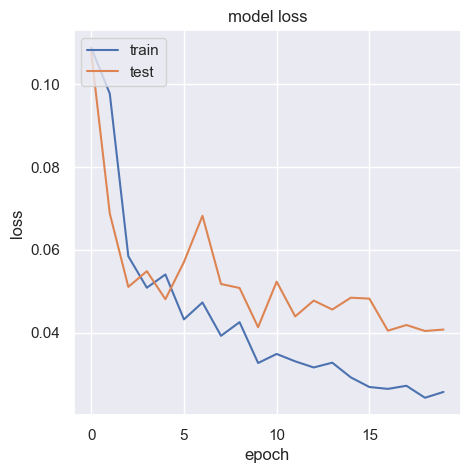

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9914 - loss: 0.0405
Metrics names: ['loss', 'compile_metrics']
Training for fold no 10


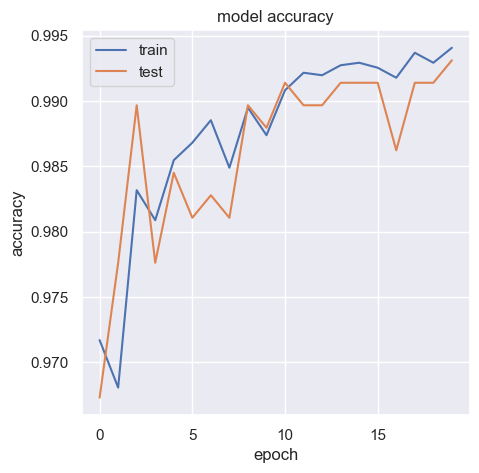

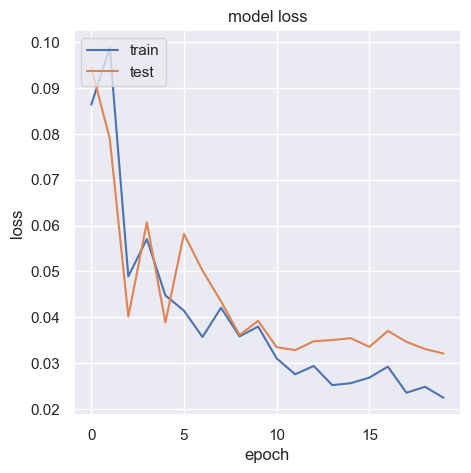

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9931 - loss: 0.0321
Metrics names: ['loss', 'compile_metrics']


In [25]:
from sklearn.model_selection import StratifiedKFold

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

fold_var = 1

skf = StratifiedKFold(n_splits = 10, random_state = 72, shuffle = True)
#Now we actually train the model. We will do 10 folds (as seen by n_splits). Initially I wanted to have each fold do 100 epochs. 
#Unfortunately, tensorflow doesn't run well on Intel CPU, and it doesn't really have support for Windows to run on GPU.
#When I tried 100 epochs per fold, it ran for 15 minutes before finally going through one fold.
#Because of that, I stuck to 20 epochs per fold, and even now the time to run is pretty large.
#If you could do that, I would suggest to modify the epochs to 100, but only if you believe your GPU can take it.
for train_index, val_index in skf.split(X_lstm, y_lstm):
    X_train = X_lstm[train_index]
    y_train = y_lstm.iloc[train_index]
    X_test = X_lstm[val_index]
    y_test = y_lstm.iloc[val_index]

    model, history = train_model(model, X_train, y_train, X_test, y_test, save_to = './', kfold_order = fold_var, epoch = 20)
    #Use the best weights to evaluate:
    model.load_weights("./_best_model_" + str(fold_var) + ".keras")

    results = model.evaluate(X_test, y_test)
    results_dict = dict(zip(model.metrics_names, results))

    #Print out the metrics for verification:
    print("Metrics names:", model.metrics_names)

    #Ensure the correct metrics:
    accuracy_metric = results_dict.get('compile_metrics')  
    loss_metric = results_dict.get('loss')

    if accuracy_metric is not None:
        VALIDATION_ACCURACY.append(accuracy_metric)
    if loss_metric is not None:
        VALIDATION_LOSS.append(loss_metric)

    tf.keras.backend.clear_session()

    fold_var += 1

In [26]:
# After all the folds, get the accuracy and loss:
if VALIDATION_ACCURACY:
    print("Average accuracy:", sum(VALIDATION_ACCURACY) / len(VALIDATION_ACCURACY))

if VALIDATION_LOSS:
    print("Average loss:", sum(VALIDATION_LOSS) / len(VALIDATION_LOSS))

Average accuracy: 0.9802272379398346
Average loss: 0.06959362253546715


Original data


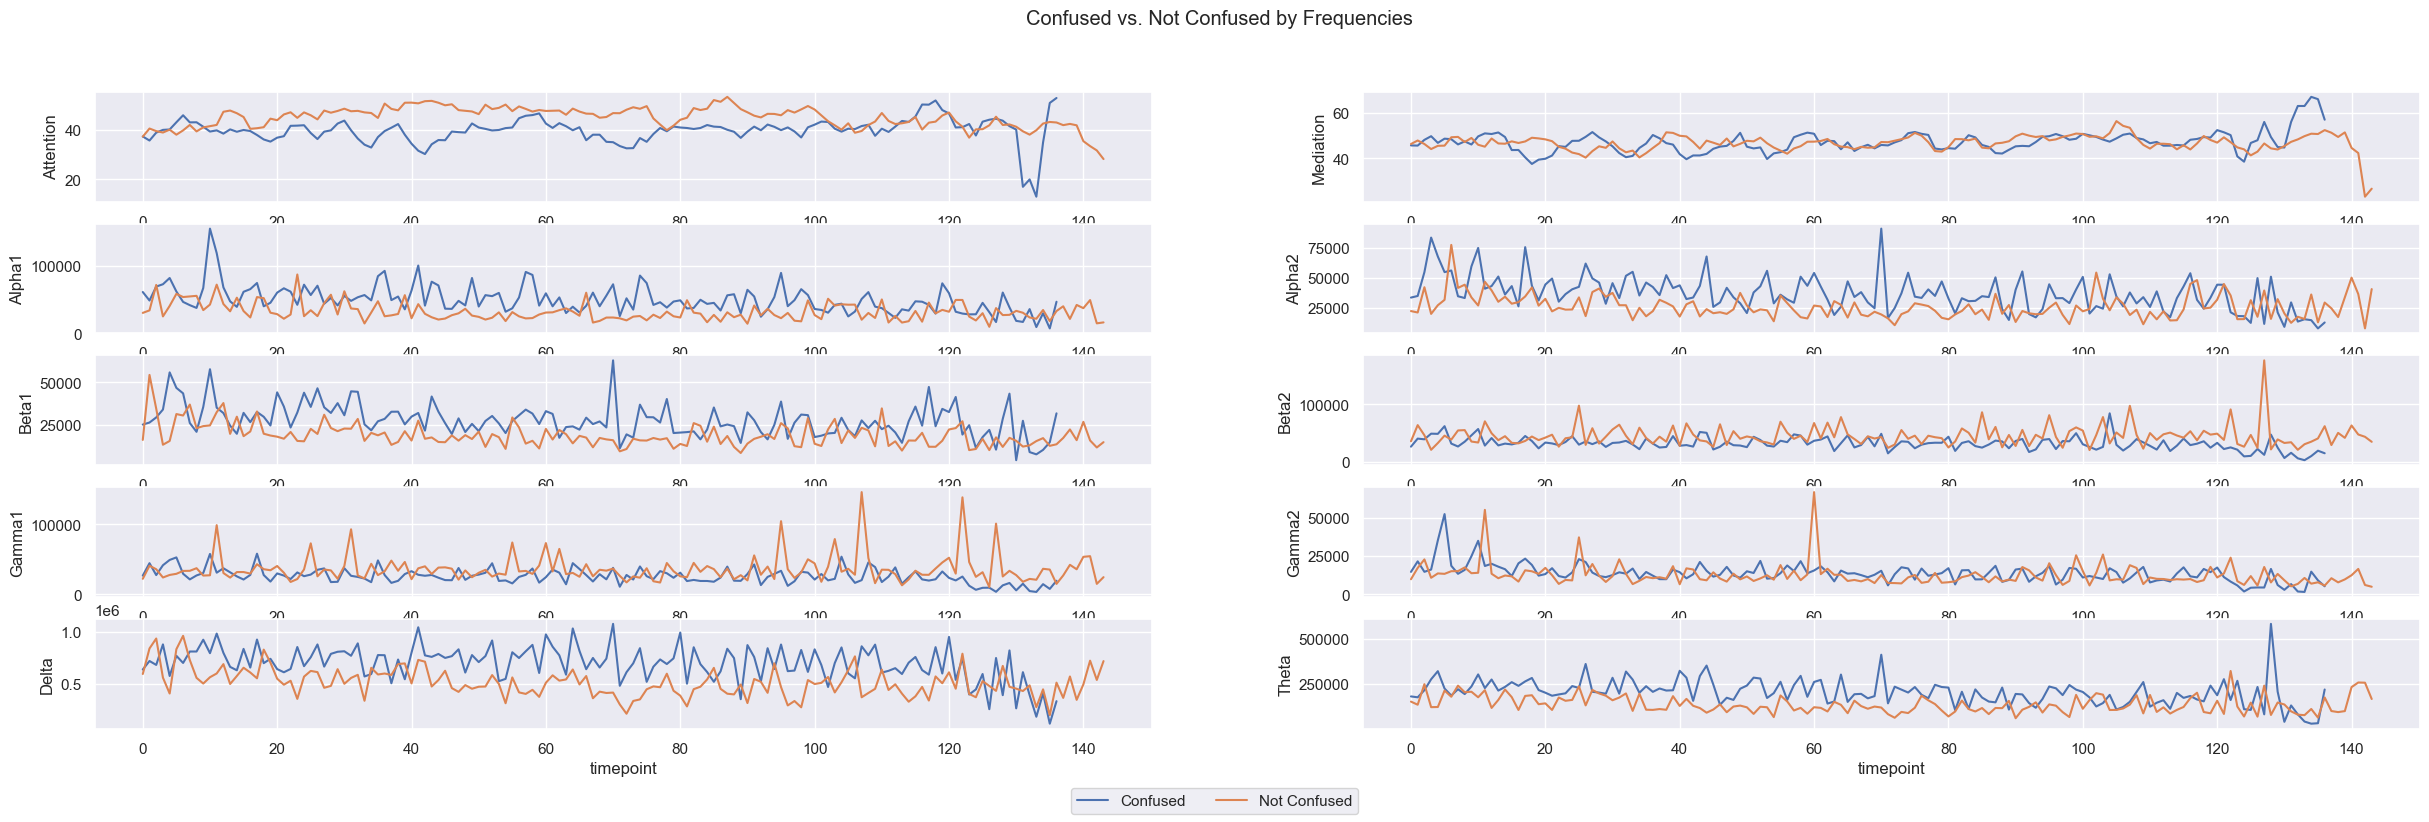

Data after applying moving average


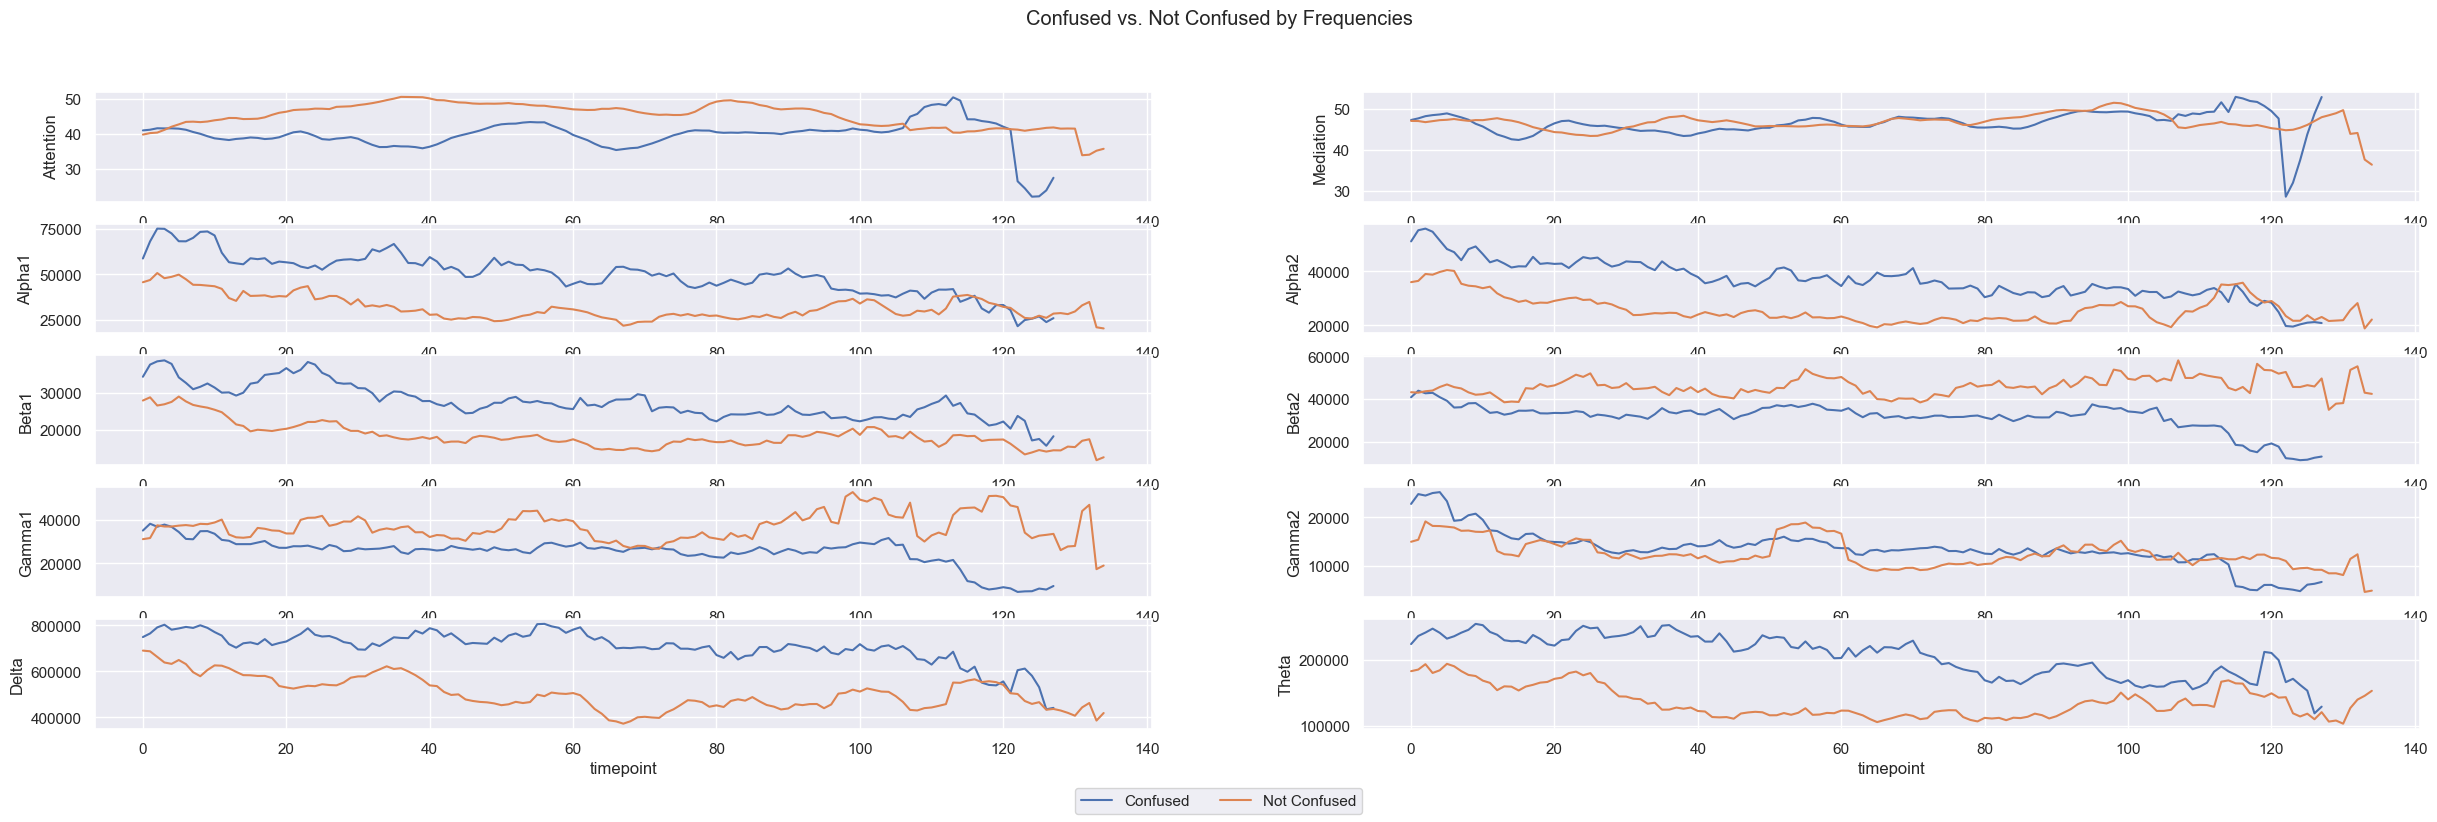

In [28]:
#Promising results. For final verification, let's look at how the moving average modified the data, and also draw a heatmap.
#We can see the improvements of our data manipulation and how we managed to have such an improvement.
query = "predefinedlabel == 1 & userlabel == 1"
EEG_confused = EEG_new.query(query)

query = "predefinedlabel == 0 & userlabel == 0"
EEG_nconfused = EEG_new.query(query)

print("===================================")
print("Original data")
print("===================================")
draw_fig(EEG_confused, EEG_nconfused, "original_data.png")

query = "Label == 1"
EEG_confused = EEG_ave.query(query)

query = "Label == 0"
EEG_nconfused = EEG_ave.query(query)

print("===================================")
print("Data after applying moving average")
print("===================================")
draw_fig(EEG_confused, EEG_nconfused, "moving_average_data.png")

<Axes: >

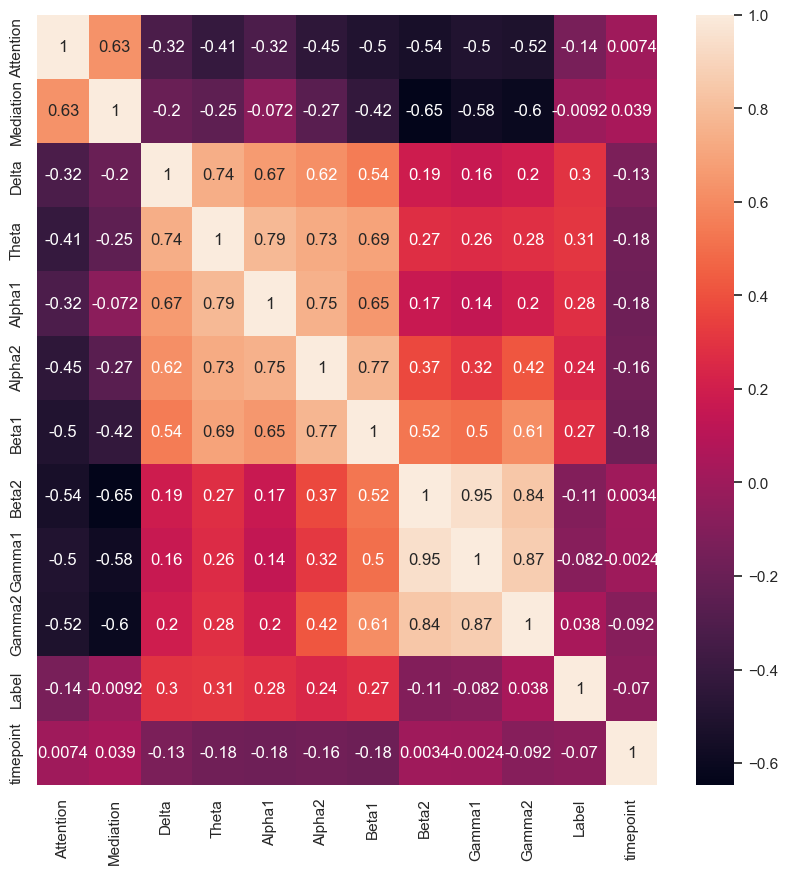

In [29]:
plt.figure(figsize = (10,10))
cor_matrix = EEG_ave.corr()
sns.heatmap(cor_matrix, annot=True)

In [33]:
print(y_test)

3     0.0
7     0.0
16    0.0
23    0.0
27    0.0
     ... 
7     1.0
64    1.0
75    1.0
76    1.0
79    1.0
Name: Label, Length: 581, dtype: float64


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


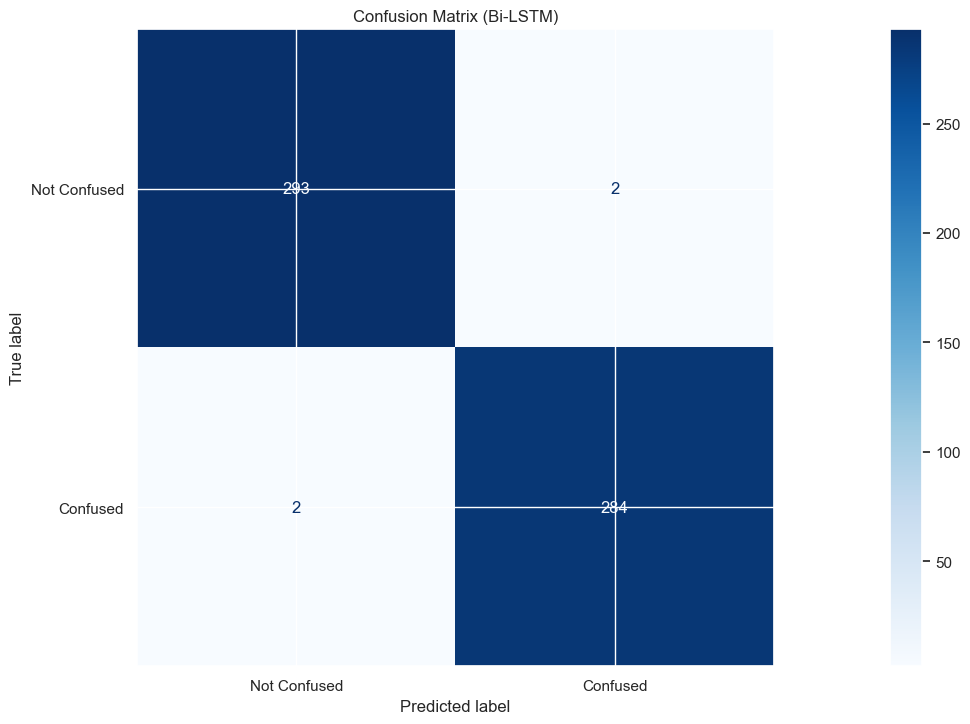

In [35]:
#I will also print a confusion matrix for the final model:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#Since we are using sigmoid activation, our prediction initially is a probablity, which we will have to convert to binary classification:
y_pp = model.predict(X_test)
y_p = (y_pp > 0.5).astype(int).flatten()

cm = confusion_matrix(y_test, y_p)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Not Confused', 'Confused'])
cm_display.plot(cmap = plt.cm.Blues)
plt.title('Confusion Matrix (Bi-LSTM)')
plt.show()